## Imports and versions

In [33]:
import warnings

In [34]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
warnings.simplefilter(action='ignore', category=Warning)

In [36]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import scipy.stats as st
import pandas as pd
import time 

In [37]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.spectrum import models
from gammapy.image.models import SkyDiffuseMap, SkyPointSource
from gammapy.cube.models import SkyModel, SkyModels
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from regions import CircleSkyRegion
from gammapy.astro.darkmatter import PrimaryFlux 
from gammapy.utils.fitting import Parameter, Parameters

In [38]:
!gammapy info --no-system


Gammapy package:

	path                   : /Users/grod/Library/Python/3.6/lib/python/site-packages/gammapy 
	version                : 0.10.dev7939 
	githash                : 48a822faa648b85b2af2e8a822bb6c62d9eeb9eb 


Other packages:

	numpy                  : 1.14.2     
	scipy                  : 1.1.0      
	matplotlib             : 3.0.2      
	cython                 : 0.28.3     
	astropy                : 3.0.3      
	astropy_healpix        : 0.3.1      
	reproject              : 0.4        
	sherpa                 : 4.10.0+18.gc1a4824-py3.6-macosx-10.9-x86_64.egg 
	pytest                 : 3.6.3      
	sphinx                 : 1.8.2      
	healpy                 : 1.9.0      
	regions                : 0.3        
	iminuit                : 1.3.2      
	naima                  : 0.8.3      
	uncertainties          : 3.0.2      


Gammapy environment variables:

	GAMMAPY_DATA           : /Users/grod/CTA/CTOOLS/software/gammapy-extra/datasets 
	GAMMAPY_EXTRA          : not set    
	G

## Simulate

In [39]:
def get_irfs():
    """Load CTA IRFs"""
    #filename = "$CALDB/data/cta/prod3b-v1/bcf/North_z20_average_50h/irf_file.fits"
    filename = "$CALDB/data/cta/prod3b-v1/bcf/South_z20_average_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)


irfs = get_irfs()

In [40]:
emin=0.03
emax=100
GLON=96.34
GLAT=-60.19

In [41]:
src_pos = SkyCoord(GLON, GLAT, unit="deg", frame="galactic")

In [42]:
pi8 = 8*np.pi;
cross_section = 0.01e-26 * u.Unit('cm3 s-1')
Jfac = 3.41e19 * u.Unit('GeV2 cm-5')
mass = 5000

In [43]:
dNdE = PrimaryFlux(1000*u.GeV, channel='b')

In [44]:
dNdE.channel_registry

{'eL': 'eL',
 'eR': 'eR',
 'e': 'e',
 'muL': '\\[Mu]L',
 'muR': '\\[Mu]R',
 'mu': '\\[Mu]',
 'tauL': '\\[Tau]L',
 'tauR': '\\[Tau]R',
 'tau': '\\[Tau]',
 'q': 'q',
 'c': 'c',
 'b': 'b',
 't': 't',
 'WL': 'WL',
 'WT': 'WT',
 'W': 'W',
 'ZL': 'ZL',
 'ZT': 'ZT',
 'Z': 'Z',
 'g': 'g',
 'gamma': '\\[Gamma]',
 'h': 'h',
 'nu_e': '\\[Nu]e',
 'nu_mu': '\\[Nu]\\[Mu]',
 'nu_tau': '\\[Nu]\\[Tau]',
 'V->e': 'V->e',
 'V->mu': 'V->\\[Mu]',
 'V->tau': 'V->\\[Tau]'}

In [45]:
#channel = ['b','tau','mu','W']
channel = ['b']

In [46]:
class UserModel(models.SpectralModel):
    def __init__(self, Norm, mass, channel_index, cross_section, Jfac):
        self.parameters = Parameters([
                Parameter('Norm', Norm, min=0),
                Parameter('mass', mass, frozen=True),
                Parameter('channel_index', channel_index, frozen=True),
                Parameter('cross_section', cross_section, frozen=True),
                Parameter('Jfac', Jfac, frozen=True)
            ])
        dNdE.mDM = mass
        dNdE.channel=channel[int(channel_index)]
    @staticmethod
    def evaluate(energy, Norm, mass, channel_index, cross_section, Jfac):
        theFlux = Norm * Jfac * cross_section * dNdE.table_model.evaluate(energy=energy, norm=1 * u.Unit('')) / mass / mass / pi8
        return theFlux

In [47]:
# Define map geometry
lg_emin = np.log10(emin)
lg_emax = np.log10(emax)
nbins = 31
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, nbins), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(GLON, GLAT), binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

In [48]:
# Define some observation parameters
pointing = SkyCoord(GLON, GLAT, unit="deg", frame="galactic")
livetime = 100 * u.hour
offset_max = 2 * u.deg
offset = Angle("2 deg")

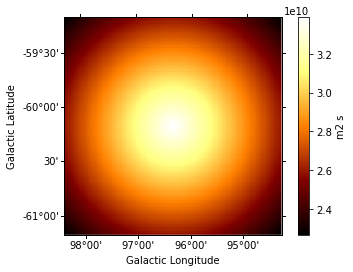

In [49]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom,
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

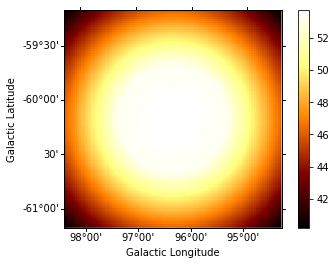

In [50]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

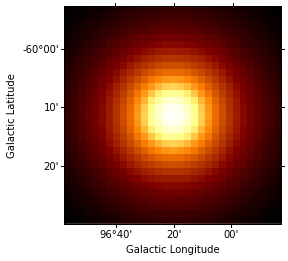

In [51]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

In [52]:
edisp = irfs["edisp"].to_energy_dispersion(offset=offset)
#edisp.plot_matrix();

In [53]:
spectral_model = UserModel(
                    Norm=1 * u.Unit(''),
                    mass = mass * u.GeV,
                    channel_index = 0 * u.Unit(''),
                    cross_section=cross_section,
                    Jfac = Jfac
)

In [54]:
# Define sky model to simulate the data
GLON=96.34
GLAT=-60.19
spatial_model =  SkyPointSource(lat_0='-60.19 deg',lon_0='96.34 deg')

In [55]:
sky_model = SkyModel(
                    spatial_model=spatial_model, spectral_model=spectral_model
                    )

In [56]:
evaluator = MapEvaluator(
    model=sky_model, exposure=exposure, background=background, psf=psf_kernel
)

In [57]:
npred = evaluator.compute_npred()
npred_map = WcsNDMap(geom, npred)

In [58]:
%%time
massval = [70, 200, 500, 5000, 10000, 50000, 100000]

columns = ['run', 'mass', 'sigma_v']
df = pd.DataFrame(columns=columns)

fNumberOfRuns = 5
for run in range(fNumberOfRuns):
    
    rng = np.random.RandomState(seed=run+int(time.time()))
    counts = rng.poisson(npred)
    counts_map = WcsNDMap(geom, counts)
       
    
    for ch in range(len(channel)):
         for mass in massval:
        
                
            spectral_model = UserModel(
                            Norm = 1 * u.Unit(''),
                            mass = mass * u.GeV,
                            channel_index = ch * u.Unit(''),
                            cross_section = cross_section,
                            Jfac = Jfac
                            )
        
            fit_model = SkyModel(
                            spatial_model=spatial_model, spectral_model=spectral_model
                            )
            
               
                
            fit_model.parameters['lat_0'].frozen=True
            fit_model.parameters['lon_0'].frozen=True
        
            fit = MapFit(
                        model=fit_model,
                        #mask=mask,
                        counts=counts_map,
                        exposure=exposure,
                        background=background,
                        psf=psf_kernel,
                        )
        
            result = fit.run()
        
            #Here is where we calculate the 95% confidence level for the Norm parameter
            pars = result.model.parameters
            delta_ts=4 # <- 3 sigma!
            stat_best_fit = fit.total_stat(pars) # <- minimum likelihood from fit
            
            def ts_diff(x):
                pars = result.model.parameters
                pars['Norm'].value = x
                stat = fit.total_stat(pars)
                return (stat_best_fit + delta_ts) - stat

            Norm = result.model.parameters['Norm'].value
            Norm_err = result.model.parameters.error('Norm')
            Norm_max = Norm + 100 * Norm_err
            Norm_min = Norm
        
            # sanity check to avoid errors with the brentq function
            factor = 100
            while (ts_diff(Norm_max) > 0 ):
                factor = factor * 5
                Norm_max = Norm + factor * Norm_err
            
            # OK we are ready to find the 95% confidence level
            scale = brentq(ts_diff, Norm_min, Norm_max, maxiter=100, rtol=1e-2)
            fSigma_v = scale * cross_section.value
            
            df = df.append({'run':run,'mass':mass, 'sigma_v':fSigma_v},
                         ignore_index=True)
    print(run)

0
1
2
3
4
CPU times: user 1min 49s, sys: 7.81 s, total: 1min 57s
Wall time: 2min 1s


In [60]:
df[['run']]  = df[['run']].astype(int)
df[['mass']] = df[['mass']].astype(int)

stats = df.groupby(['mass']).mean()
stats2 = df.groupby(['mass']).std()

print(stats.head())
print(stats2.head())

       run       sigma_v
mass                    
70       2  1.057065e-23
200      2  2.201501e-24
500      2  1.361085e-24
5000     2  1.305551e-24
10000    2  1.435316e-24
            run       sigma_v
mass                         
70     1.581139  4.411086e-24
200    1.581139  7.571206e-25
500    1.581139  3.762850e-25
5000   1.581139  5.412231e-25
10000  1.581139  8.346115e-25


In [61]:
stats2.columns = ['std_run', 'std_sigma_v']
stats = pd.merge(stats,stats2, left_index=True, right_index=True)

stats.to_csv('gammapy_example.dat',sep=' ')

In [62]:
test = pd.read_csv('gammapy_example.dat', delim_whitespace=True)

In [63]:
test.drop(['run','std_run'],axis=1, inplace=True)

In [64]:
test.head(10)

,mass,sigma_v,std_sigma_v
0,70,1.057065e-23,4.411086e-24
1,200,2.201501e-24,7.571206e-25
2,500,1.361085e-24,3.762850e-25
3,5000,1.305551e-24,5.412231e-25
4,10000,1.435316e-24,8.346115e-25
5,50000,2.690816e-24,1.816731e-24
6,100000,4.566855e-24,2.334890e-24


In [65]:
test.dropna(inplace=True)

In [66]:
test.head(10)

,mass,sigma_v,std_sigma_v
0,70,1.057065e-23,4.411086e-24
1,200,2.201501e-24,7.571206e-25
2,500,1.361085e-24,3.762850e-25
3,5000,1.305551e-24,5.412231e-25
4,10000,1.435316e-24,8.346115e-25
5,50000,2.690816e-24,1.816731e-24
6,100000,4.566855e-24,2.334890e-24


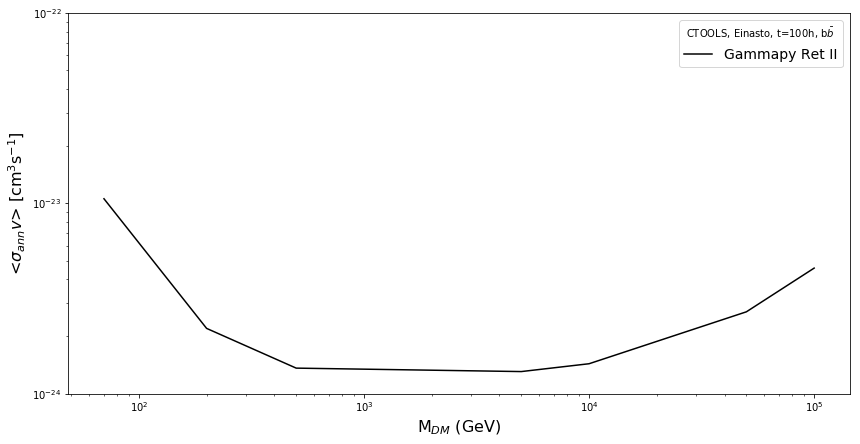

In [67]:
fig, ax1 = plt.subplots(1, figsize=(14, 7))

ax1.loglog(test['mass'],test['sigma_v'], color='black', ls='-', label='Gammapy Ret II')

ax1.set_xlabel('M$_{DM}$ (GeV)', fontsize=16)
ax1.set_ylabel(r"<$\sigma_{ann}v$> [cm$^3$s$^{-1}$]", fontsize=16)
ax1.set_ylim(1e-24,1e-22)
ax1.legend(title=r"CTOOLS, Einasto, t=100h, b$\bar{b}$", fontsize=14)